# Markov Chain Monte Carlo Simulation As An Informed Fuzzing Technique

## By: Chris Vaisnor

Markov Chain Monte Carlo Library: https://github.com/dflemin3/approxposterior

The idea:
Get a random array of binary values to return a boolean value when passed through a hidden "black box" function. Using a Markov Chain Monte Carlo (MCMC) method, we can find the constraints of the hidden function.

Input will be a numpy array of binary values. Output will be an integer indicating success or failure.

Ex: 
- Input: [0, 1, 0, 1, 1, 0, 0, 1, 1, 1]
- Output: 0 (failure)

In [1]:
import numpy as np

In [2]:
# input array of theta will always be a 10 item numpy array with each element being a 1 or 0

def create_test_data(number_of_samples = 100, length = 10):
    all_observations = []

    #TODO: seed the random number generator

    for i in range(number_of_samples):
        theta = np.random.randint(2, size=length)
        all_observations.append(theta)

    return all_observations

In [3]:
test_data = create_test_data()

In [4]:
print('First 10 samples of test data:')
for i in range(10):
    print(test_data[i])

First 10 samples of test data:
[0 1 0 1 0 0 1 0 0 0]
[1 1 1 1 1 0 0 1 0 0]
[0 1 0 0 1 1 0 1 0 0]
[0 1 1 0 1 1 0 0 1 1]
[1 1 0 0 0 0 0 1 1 1]
[0 1 0 0 0 1 0 1 0 1]
[1 0 1 0 1 0 0 1 0 1]
[0 0 0 0 0 0 1 0 1 0]
[1 1 0 0 1 1 0 1 0 0]
[1 0 0 0 0 1 1 0 1 0]


In [5]:
def black_box_function(theta):
    # theta is a 10 item numpy array with each element being a 1 or 0
    
    # if theta is all 1s, return 1
    if np.sum(theta) == 10:
        return 1
    else:
        return 0

# Markov Chain Monte Carlo (MCMC) Library Demo

In [6]:
from approxposterior import approx, gpUtils, likelihood as lh, utility as ut

# Define algorithm parameters
training_set_size = 50                           # Initial size of training set
new_points_per_iteration = 20                            # Number of new points to find each iteration
max_iterations = 5                        # Maximum number of iterations
prior_bounds = [(-5,5), (-5,5)]         # Prior bounds
algorithm = "bape"                # Use the Kandasamy et al. (2017) formalism
seed = 57                         # RNG seed
np.random.seed(seed)

# emcee MCMC parameters
samplerKwargs = {"nwalkers" : 20}        # emcee.EnsembleSampler parameters
mcmcKwargs = {"iterations" : int(2.0e4)} # emcee.EnsembleSampler.run_mcmc parameters

# Sample design points from prior
theta = lh.rosenbrockSample(training_set_size)

# Evaluate forward model log likelihood + lnprior for each theta
y = np.zeros(len(theta))
for ii in range(len(theta)):
    y[ii] = lh.rosenbrockLnlike(theta[ii]) + lh.rosenbrockLnprior(theta[ii])

# Default GP with an ExpSquaredKernel
gp = gpUtils.defaultGP(theta, y, white_noise=-12)

# Initialize object using the Wang & Li (2018) Rosenbrock function example
approximate_posterior = approx.ApproxPosterior(theta=theta,
                            y=y,
                            gp=gp,
                            lnprior=lh.rosenbrockLnprior,
                            lnlike=lh.rosenbrockLnlike,
                            priorSample=lh.rosenbrockSample,
                            bounds=prior_bounds,
                            algorithm=algorithm)

## WARNING: **very** computationally expensive

In [7]:
# Run
approximate_posterior.run(m=new_points_per_iteration, nmax=max_iterations, estBurnin=True, nGPRestarts=3, mcmcKwargs=mcmcKwargs,
                     cache=False, samplerKwargs=samplerKwargs, verbose=True, thinChains=False, onlyLastMCMC=True)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Defaulting to nwalkers samples from priorSample.
mcmc finished
burn-in estimate: 279
thin estimate: 1


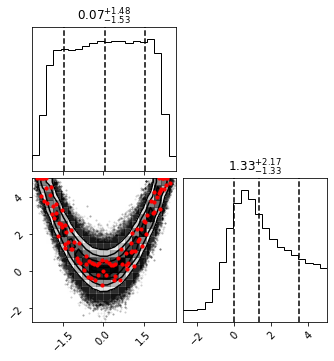

In [8]:
# Check out the final posterior distribution!
import corner

# Load in chain from last iteration
samples = approximate_posterior.sampler.get_chain(discard=approximate_posterior.iburns[-1], flat=True, thin=approximate_posterior.ithins[-1])

# Corner plot!
fig = corner.corner(samples, quantiles=[0.16, 0.5, 0.84], show_titles=True,
                    scale_hist=True, plot_contours=True)

# Plot where forward model was evaluated - uncomment to plot!
fig.axes[2].scatter(approximate_posterior.theta[training_set_size:,0], approximate_posterior.theta[training_set_size:,1], s=10, color="red", zorder=20)

# Save figure
fig.savefig("finalPosterior.png", bbox_inches="tight")

# Sequential Monte Carlo (SMC) Library Demo

In [9]:
import approxbayescomp as abc

# Load data to fit (modify this line to load real observations!)
obsData = [1.0, 2.0, 3.0]

# Specify our prior beliefs over (lambda, mu, sigma).
priors = abc.IndependentUniformPrior([(0, 100), (-5, 5), (0, 3)])

# Fit the model to the data using ABC
model = abc.Model("poisson", "lognormal", abc.Psi("sum"), priors)
numIters = 6  # The number of SMC iterations to perform
popSize = 250  # The population size of the SMC method

fit = abc.smc(numIters, popSize, obsData, model, priors)

print("Posterior mean of lambda: ", np.sum(fit.samples[:, 0] * fit.weights))
print("Posterior mean of mu: ", np.sum(fit.samples[:, 1] * fit.weights))
print("Posterior mean of sigma: ", np.sum(fit.samples[:, 2] * fit.weights))

Posterior mean of lambda:  30.71981528186295
Posterior mean of mu:  -3.557442176520678
Posterior mean of sigma:  1.5242830780695735
